# TP Operaciones de Aprendizaje Automático 1
## Dataset utilizado ["Crímenes reportados en Chicago", año 2024](https://data.cityofchicago.org/Public-Safety/Crimes-2024/dqcy-ctma/about_data) 

Integrantes:
* Mealla Pablo
* Mendoza Dante
* Vasquez Jorge
* Viñas Gustavo

### Descripción de columnas según información provista en el origen del dataset

| Nombre columna | Descripción | Tipo de dato |
| --- | --- | --- |
|	ID	|	Unique identifier for the record.	|	Number	|
|	Case Number	|	The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.	|	Text	|
|	Date	|	Date when the incident occurred. this is sometimes a best estimate.	|	Floating Timestamp	|
|	Block	|	The partially redacted address where the incident occurred, placing it on the same block as the actual address.	|	Text	|
|	IUCR	|	The Illinois Uniform Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.	|	Text	|
|	Primary Type	|	The primary description of the IUCR code.	|	Text	|
|	Description	|	The secondary description of the IUCR code, a subcategory of the primary description.	|	Text	|
|	Location Description	|	Description of the location where the incident occurred.	|	Text	|
|	Arrest	|	Indicates whether an arrest was made.	|	Checkbox	|
|	Domestic	|	Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.	|	Checkbox	|
|	Beat	|	Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.	|	Text	|
|	District	|	Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.	|	Text	|
|	Ward	|	The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.	|	Number	|
|	Community Area	|	Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.	|	Text	|
|	FBI Code	|	Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).See the Chicago Police Department listing of these classifications at https://gis.chicagopolice.org/pages/crime_details.	|	Text	|
|	X Coordinate	|	The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.	|	Number	|
|	Y Coordinate	|	The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.	|	Number	|
|	Year	|	Year the incident occurred.	|	Number	|
|	Updated On	|	Date and time the record was last updated.	|	Floating Timestamp	|
|	Latitude	|	The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.	|	Number	|
|	Longitude	|	The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.	|	Number	|
|	Location	|	The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.	|	Point	|

## Objetivo: 

El propósito de este trabajo es analizar un conjunto de datos públicos sobre crímenes reportados en la ciudad de Chicago durante el año 2024, con el objetivo de explorar la posibilidad de predecir la categoría del delito según el sistema de codificación del FBI (FBI Code), en función de otras variables conocidas del incidente como el tipo de crimen, el lugar donde ocurrió, el momento temporal (día, hora, mes), o si se trató de un crimen doméstico o no. Entre otras variables disponibles en el dataset.

El FBI Code es un código numérico asignado a cada incidente criminal para clasificarlo según las categorías establecidas por el FBI en su programa Uniform Crime Reporting (UCR). Cada código representa un grupo de delitos similares, por ejemplo:
- Código 01A → Homicidio criminal
- Código 06 → Robo (theft)
- Código 04A → Agresión con agravantes... etc.

## Configuración inicial de MLFlow

In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


### Habilitamos el Tracking de MLFlow para registrar parámetros y resultados del modelo

In [2]:
mlflow.set_tracking_uri('http://localhost:5000')

### Creamos el experimento

In [3]:
experiment_name='Chicago_Crimes'

exp = mlflow.get_experiment_by_name(experiment_name)

if exp is None:
    mlflow.create_experiment(name=experiment_name)

mlflow.set_experiment(experiment_name)




<Experiment: artifact_location='mlflow-artifacts:/372625047834839028', creation_time=1754007704595, experiment_id='372625047834839028', last_update_time=1754007704595, lifecycle_stage='active', name='Chicago_Crimes', tags={}>

### Guardamos el archivo csv con los datos del dataset como un artefacto de MLFlow

In [4]:
csv = "dataset/Crimes_-_2024_20250619.zip"
df_csv = pd.read_csv(csv)

# Guardo el csv como un artefacto en mlflow
with mlflow.start_run():
    mlflow.log_artifact(csv, artifact_path="datasets")



🏃 View run abundant-gull-476 at: http://localhost:5000/#/experiments/372625047834839028/runs/ce89a1c9e9184d22b1753d56f7c0b4e3
🧪 View experiment at: http://localhost:5000/#/experiments/372625047834839028


## 🔎 Análisis exploratorio y tratamiento de variables.

En esta sección se explora el comportamiento de las principales variables del dataset y se aplican transformaciones necesarias para su análisis, como conversión de tipos, creación de variables derivadas y manejo de valores atípicos, nulos o duplicados.


In [5]:
# Analizamos filas duplicadas, sin considerar las siguientes columnas
drop_columns = ["ID", "Date", "Updated On"]
df_dup = df_csv.drop(drop_columns, axis=1)

# Ordenamos por fecha de crimen y de actualización, para que al momento de eliminar duplicados, podamos quedarnos con el último
# Eliminamos los duplicados obtenidos, consideramos los iguales ignorando la fecha del suceso, la actualización, y el id del dataset (que no es el id del suceso).
df_csv.sort_values(axis=0, by=["Updated On", "Date"], ascending=True).drop_duplicates(df_dup.columns, keep='last', inplace=True)

# Convertimos columnas del dataset al tipo correcto y agregamos datos extraidos de la fecha
df_csv["Date"] = pd.to_datetime(df_csv["Date"], format="%m/%d/%Y %I:%M:%S %p")
df_csv["mes"] = df_csv["Date"].dt.month
df_csv["dia_mes"] = df_csv["Date"].dt.day
df_csv["dia_semana"] = df_csv["Date"].dt.dayofweek
df_csv["hora"] = df_csv["Date"].dt.hour

categorical_cols = ['IUCR', 'Primary Type', 'Description', 'Location Description', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code']
df_csv[categorical_cols] = df_csv[categorical_cols].astype('category')

# Eliminamos columnas que consideramos no tienen aporte significativo, o que tiene valores únicos para cada fila (ids)
drop_columns = ["ID", "Date", "Case Number", "Block", "X Coordinate", "Y Coordinate", "Year", "Updated On", "Location"]
df_csv.drop(drop_columns, inplace=True, axis=1)

df_csv.dropna(inplace=True)

# Como Community Area tenía nulos, la reconoció como float, pero sabemos que son números enteros, por lo tanto, una vez eliminados los nulos la convertimos a int y luego a categórica
df_csv["Community Area"] = df_csv["Community Area"].astype('int').astype('category')

# Vemos que solo los casos del District 31 tienen diferencias, podemos solucionarlo reemplazando por el District calculado a partir de Beat
df_csv.loc[df_csv["District"] == 31, "District"] = df_csv.loc[df_csv["District"] == 31, "Beat"].astype(int) // 100
df_csv["District"] = df_csv["District"].cat.remove_unused_categories()


#### Analizamos la variable target (FBI CODE)

In [6]:
target = 'FBI Code'

# Primero separamos los features y el target
X = df_csv.drop(columns=[target])
y = df_csv[target]



### Observemos gráficamente la distribución y desbalance en FBI CODE y la guardamos en MLFlow como un artefacto:

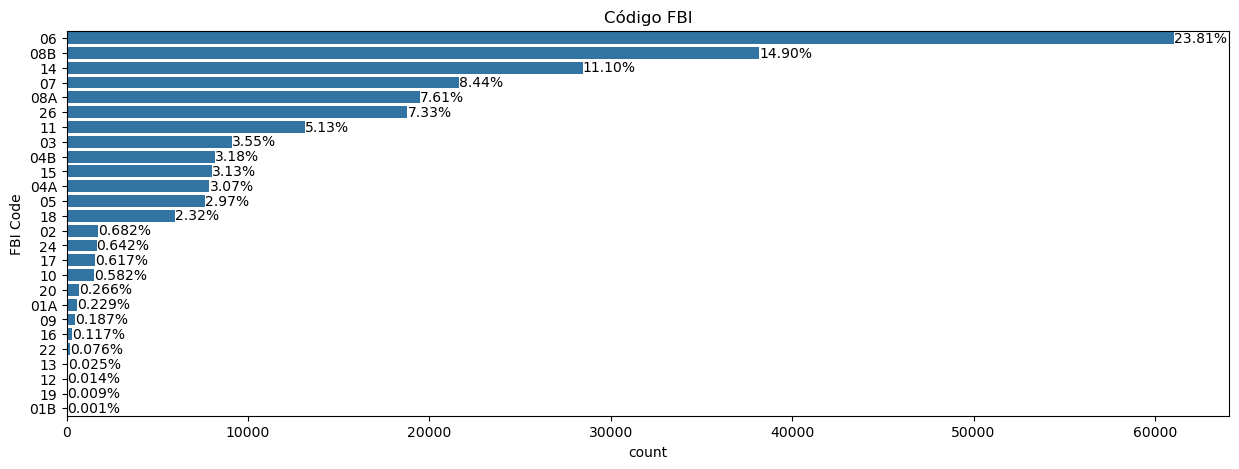

🏃 View run delightful-sow-886 at: http://localhost:5000/#/experiments/372625047834839028/runs/e89e57beaac54d6a9795349ac0f3cf2a
🧪 View experiment at: http://localhost:5000/#/experiments/372625047834839028


In [7]:
# Graficamos la distribución de FBI Code

fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=y, order=y.value_counts().index, ax=ax)
total = y.count()
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.2f}%' if (x/total) > 0.01 else f'{(x/total)*100:0.3f}%')
ax.set_title('Código FBI')
plt.show()

# Guardar figura a archivo
output_path = "grafico_codigo_fbi.png"
fig.savefig(output_path, bbox_inches='tight')

with mlflow.start_run():
    mlflow.log_artifact(output_path, artifact_path="graficos")


### Quitamos la clase "01B" que tiene solo 2 observaciones para evitar que el y_test quede con el valor 0


In [8]:
# Quitamos la clase que tiene solo 2 observaciones, porque en el y_test quedó con 0.
y_count = y.value_counts()
y_count[y_count<5]
drop_index = y[y == "01B"].index
y=y.drop(drop_index).cat.remove_unused_categories()
X=X.drop(drop_index)

### Transformación de variables - Encoding

#### Antes de continuar con la transformación, debemos separar en train y test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Para empezar el análisis, observamos la cardinalidad de las variables categóricas que queremos codificar

In [10]:
X_train.describe(include="category")

IUCR Primary Type Description Location Description    Beat  \
count   205043       205043      205043               205043  205043   
unique     333           31         311                  122     275   
top       0486        THEFT      SIMPLE               STREET    1834   
freq     16293        48187       25059                55580    2472   

        District    Ward  Community Area  
count     205043  205043          205043  
unique        22      50              77  
top            8      27              25  
freq       13698    9557           10193

In [11]:
X_train.describe()

Latitude      Longitude            mes        dia_mes  \
count  205043.000000  205043.000000  205043.000000  205043.000000   
mean       41.847332     -87.668883       6.554215      15.648820   
std         0.086792       0.058881       3.354055       8.898229   
min        41.644590     -87.934324       1.000000       1.000000   
25%        41.772532     -87.709807       4.000000       8.000000   
50%        41.865608     -87.661846       7.000000      16.000000   
75%        41.910045     -87.627319       9.000000      23.000000   
max        42.022536     -87.524531      12.000000      31.000000   

          dia_semana           hora  
count  205043.000000  205043.000000  
mean        2.999902      12.523266  
std         2.008291       6.857606  
min         0.000000       0.000000  
25%         1.000000       8.000000  
50%         3.000000      13.000000  
75%         5.000000      18.000000  
max         6.000000      23.000000

In [12]:
numericas = ["Latitude", "Longitude"]
ordinales = [] # No tenemos features ordinales
cardinalidad_baja = ["Arrest", "Domestic", "dia_semana"]
cardinalidad_media = ["IUCR", "Primary Type", "Description", "Location Description", "Beat", "District", "Ward", "Community Area", "mes", "dia_mes", "hora"]

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

# En nuestro dataset no quedaron nulos, pero definimos imputaciones por si acaso vinieran nulos

# Convierte el dato en string
def to_str(X):
    return X.astype(str)

transformar_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# No tenemos ordinales, pero podríamos usar la siguiente transformación si hubiera
transformar_ordinales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

transformar_bajacard = Pipeline(steps=[
    ('to_str', FunctionTransformer(to_str, validate=False)), # Para que no falle con categoricas string
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # drop=first para reducir los features
])

transformar_nominales = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(handle_unknown='value')), # Si se encuentra con una categoría desconocida, codifica con la media global del set de entrenamiento
    ('scaler', MinMaxScaler()),
])

In [14]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformar_numericas, numericas),
        ('ord', transformar_ordinales, ordinales),
        ('bin', transformar_bajacard, cardinalidad_baja),
        ('nom', transformar_nominales, cardinalidad_media)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Hacemos fit y transform sobre train
X_train_procesado = pipeline.fit_transform(X_train, y_train)

# Vemos como quedó el pipeline
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Latitude', 'Longitude']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('scaler'...
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Arrest', 'Domestic',
                                                   'dia_semana']),
                                                 ('nom',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['IUCR', 'Primary Type',
                                                   'Description',
                                                   'Location Description',
                                                   'Beat', 'District', 'Ward',
                                                   'Community Area', 'mes',
                                                   'dia_mes', 'hora'])]))])

In [15]:
# Ahora aplicamos el transform en test
X_test_procesado = pipeline.transform(X_test)

Reconstruimos el dataset para ver que hizo

In [16]:
numericas_salida = numericas # las numéricas transformadas
ordinales_salida = ordinales # las ordinales transformadas
nominales_salida = cardinalidad_media # las categoricas de cardinalidad media transformadas

binarias_salida = pipeline.named_steps['preprocessor'].named_transformers_['bin'].named_steps['onehot'].get_feature_names_out(cardinalidad_baja)

# Armamos los nombres de las variables en orden de acuerdo a la pipeline
transformed_feature_names = (
    list(numericas_salida) +
    list(ordinales_salida) +
    list(binarias_salida) +
    list(nominales_salida) 
)

# Reconstruimos el dataframe procesado
X_train_preproc = pd.DataFrame(X_train_procesado, columns=transformed_feature_names)
X_test_preproc = pd.DataFrame(X_test_procesado, columns=transformed_feature_names)

with pd.option_context('display.max_columns', None):
    display(X_train_preproc.head(10))

Latitude  Longitude  Arrest_True  Domestic_True  dia_semana_1  \
0  0.705400   0.739857          0.0            0.0           1.0   
1  0.666464   0.756583          0.0            0.0           0.0   
2  0.306819   0.839444          0.0            0.0           1.0   
3  0.745313   0.342176          0.0            1.0           1.0   
4  0.701281   0.461265          0.0            0.0           1.0   
5  0.687490   0.754691          1.0            1.0           0.0   
6  0.758853   0.713601          0.0            1.0           0.0   
7  0.388723   0.351389          0.0            0.0           1.0   
8  0.773231   0.425076          1.0            1.0           0.0   
9  0.444299   0.730618          0.0            0.0           0.0   

   dia_semana_2  dia_semana_3  dia_semana_4  dia_semana_5  dia_semana_6  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           1.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   
5           0.0           0.0           0.0           0.0           1.0   
6           0.0           0.0           1.0           0.0           0.0   
7           0.0           0.0           0.0           0.0           0.0   
8           0.0           0.0           1.0           0.0           0.0   
9           0.0           1.0           0.0           0.0           0.0   

       IUCR  Primary Type  Description  Location Description      Beat  \
0  0.291667      0.291667     0.291667              0.546945  0.174323   
1  0.375000      0.337998     0.354565              0.493605  0.228493   
2  0.666667      0.666667     0.666667              0.488566  0.305776   
3  1.000000      0.863952     1.000000              0.629998  0.318675   
4  0.250000      0.250000     0.250000              0.378995  0.316430   
5  0.375000      0.337998     0.375000              0.629998  0.247152   
6  0.625000      0.625000     0.625000              0.557087  0.054164   
7  0.208333      0.212302     0.208333              0.416077  0.432941   
8  0.375000      0.337998     0.375000              0.629998  0.438006   
9  0.333333      0.263045     0.358610              0.472431  0.263973   

   District      Ward  Community Area       mes   dia_mes      hora  
0  0.158116  0.033543        0.000000  0.000000  0.524416  0.456648  
1  0.158116  0.298460        0.330690  0.166885  0.401569  0.613730  
2  0.347722  0.528713        0.369887  0.907779  0.743912  0.245062  
3  0.473555  0.480440        0.626980  0.907779  0.000000  0.825612  
4  0.473555  0.767911        0.559394  0.467571  0.584236  0.869498  
5  0.158116  0.033543        0.330690  0.651328  0.195111  1.000000  
6  0.000000  0.033543        0.000000  0.605180  0.437261  1.000000  
7  0.591487  0.938883        0.889100  0.166885  0.000000  0.584833  
8  0.473555  0.629264        0.572274  0.159804  0.524531  0.773974  
9  0.371417  0.686233        0.418592  0.897599  0.275932  0.589101

# 🛠 Armado y busqueda de modelo.

En esta sección, mostraremos cuáles fueron los pasos a seguir para el armado y búsqueda de modelos de predicción.

En primer lugar creamos una función para mostrar y guardar las métricas del modelo


In [17]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def metrics(model, X_test, y_test, graphcm=False, log_mlflow=True):
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

    # Mostrar por consola
    print(f"La exactitud de clasificación es de: {accuracy:.3f}")
    with pd.option_context('display.max_columns', None):
        show_df = pd.DataFrame([precision, recall, f1], index=["Precision", "Recall", "f1"], columns=y_test.cat.categories)
        display(show_df.round(2))

    # Registrar métricas en MLflow
    if log_mlflow:
        mlflow.log_metric("accuracy", accuracy)
        for i, cat in enumerate(y_test.cat.categories):
            mlflow.log_metric(f"precision_{cat}", precision[i])
            mlflow.log_metric(f"recall_{cat}", recall[i])
            mlflow.log_metric(f"f1_{cat}", f1[i])

    # Graficar y guardar matriz de confusión
    if graphcm:
        cm = confusion_matrix(y_test, y_pred, labels=y_test.cat.categories)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.cat.categories)

        fig, ax = plt.subplots(figsize=(15, 15))
        ax.grid(False)
        disp.plot(ax=ax)

        # Guardar la figura
        img_path = "confusion_matrix.png"
        fig.savefig(img_path, bbox_inches='tight')

        # Registrar como artefacto
        if log_mlflow:
            mlflow.log_artifact(img_path, artifact_path="graficos")

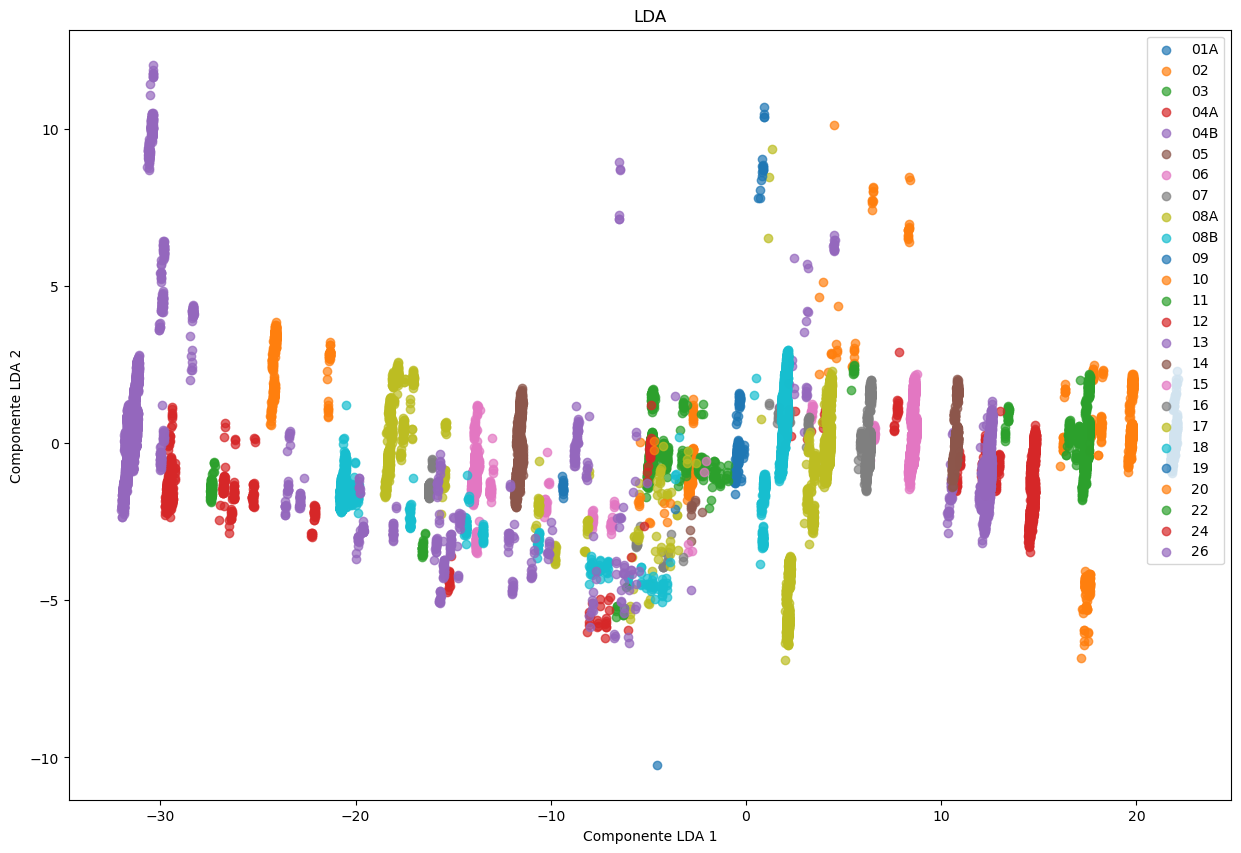

Porcentaje de varianza capturada por cada componente:
[0.99133585 0.00342338]
Porcentaje de varianza acumulada:
[0.99133585 0.99475923]


In [18]:
# Aplicamos reducción LDA para visualizar las clases

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_preproc, y_train)

target_names = y.cat.categories
plt.figure(figsize=(15, 10))
for _, target_name in enumerate(target_names):
    plt.scatter(X_train_lda[y_train == target_name, 0], X_train_lda[y_train == target_name, 1], label=target_name, alpha=0.7)
plt.xlabel("Componente LDA 1")
plt.ylabel("Componente LDA 2")
plt.legend()
plt.title("LDA")
plt.show()

print(f"Porcentaje de varianza capturada por cada componente:\n{lda.explained_variance_ratio_}")
print(f"Porcentaje de varianza acumulada:\n{np.cumsum(lda.explained_variance_ratio_)}")

# Aplicamos a los datos de test
X_test_lda = lda.transform(X_test_preproc)


### Visualizamos los resultados del modelo LDA y los guardamos en MLFlow

Resultados para set training:
La exactitud de clasificación es de: 0.779


01A    02    03   04A   04B    05    06    07   08A   08B    09  \
Precision  1.0  1.00  0.95  0.98  0.98  0.99  0.98  0.99  1.00  0.98  0.99   
Recall     1.0  0.58  0.99  0.97  0.99  0.82  1.00  1.00  0.98  1.00  0.66   
f1         1.0  0.74  0.97  0.97  0.99  0.89  0.99  0.99  0.99  0.99  0.79   

             10    11   12    13    14    15    16    17    18    19    20  \
Precision  0.85  0.94  0.0  0.96  0.90  0.80  0.43  0.93  0.96  0.12  0.99   
Recall     0.63  0.99  0.0  0.51  0.97  0.59  0.54  0.83  0.96  0.83  0.97   
f1         0.72  0.96  0.0  0.67  0.93  0.68  0.48  0.88  0.96  0.21  0.98   

            22    24    26  
Precision  0.0  0.88  0.98  
Recall     0.0  0.69  0.98  
f1         0.0  0.77  0.98

Resultados para set test:
La exactitud de clasificación es de: 0.785


01A    02    03   04A   04B    05    06    07   08A   08B    09  \
Precision  0.99  1.00  0.95  0.98  0.98  0.99  0.98  0.99  1.00  0.98  1.00   
Recall     1.00  0.60  0.99  0.97  0.99  0.82  1.00  0.99  0.97  1.00  0.61   
f1         1.00  0.75  0.97  0.98  0.99  0.90  0.99  0.99  0.98  0.99  0.76   

             10    11   12    13    14    15    16    17    18    19    20  \
Precision  0.86  0.94  0.0  1.00  0.90  0.80  0.36  0.93  0.96  0.13  0.98   
Recall     0.61  0.99  0.0  0.62  0.97  0.59  0.48  0.85  0.95  1.00  0.96   
f1         0.72  0.96  0.0  0.76  0.93  0.68  0.41  0.89  0.96  0.23  0.97   

            22    24    26  
Precision  0.0  0.89  0.98  
Recall     0.0  0.65  0.98  
f1         0.0  0.75  0.98

🏃 View run Evaluación LDA at: http://localhost:5000/#/experiments/372625047834839028/runs/de3a7e7e497b450f907f423651640586
🧪 View experiment at: http://localhost:5000/#/experiments/372625047834839028


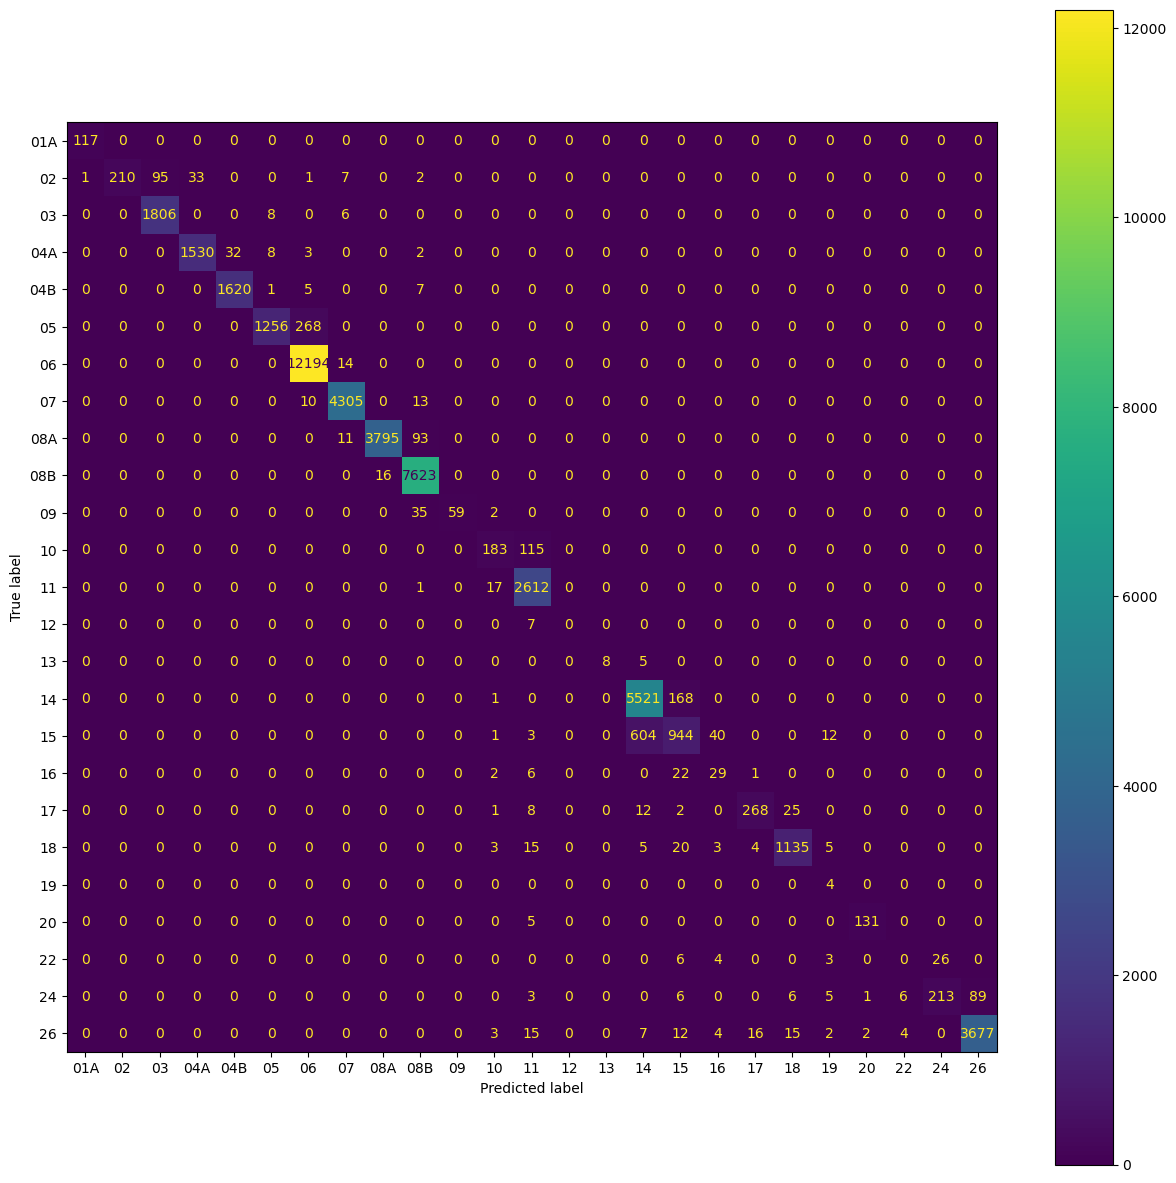

In [20]:
with mlflow.start_run(run_name="Evaluación LDA"):
    print("Resultados para set training:")
    metrics(lda, X_train_preproc, y_train)
    print("Resultados para set test:")
    metrics(lda, X_test_preproc, y_test, True)

Pero en este caso vamos a usar LDA para reducir la dimensionalidad en los siguientes modelos

#### Clasificación multi-clase con SVM

- 'ovo': Estrategia One vs one
- 'ovr': Estrategia One vs rest (One vs all).

Entrenamos un primer modelo SVM, con variables establecidas sin ningún criterio

In [ ]:
from sklearn.svm import SVC

svm_rbf_ovr = SVC(kernel="rbf", C=1, gamma=0.1, decision_function_shape='ovr', random_state=42); 
svm_rbf_ovr.fit(X_train_lda, y_train)

In [ ]:
print("Resultados para set training:")
metrics(svm_rbf_ovr, X_train_lda, y_train)
print("Resultados para set test:")
metrics(svm_rbf_ovr, X_test_lda, y_test, True)

Con estas variables vemos que el resultado obtenido es bastante bueno. El modelo generaliza bien con una exactitud >90%.
Excepto para alguna categoría en particular, donde obtuvo muy bajo puntaje (FBI Code 12).

Buscamos mejores hiperparámetros mediante Optimización Bayesiana

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Definir el espacio de búsqueda para la optimización bayesiana
search_spaces = {
    'decision_function_shape': Categorical(['ovo', 'ovr']),
    'C': Real(0.1, 100, prior='uniform'),
    'gamma': Real(0.1, 10, prior='uniform')
}

# Configurar la optimización bayesiana con validación cruzada
opt = BayesSearchCV(
    SVC(kernel="rbf", random_state=42),
    search_spaces,
    n_iter=20,  # Número de iteraciones de optimización.
    n_points=4,
    cv=3,       # Validación cruzada triple
    n_jobs=12,   
    random_state=42,
    verbose=1
)

# Ejecutar la optimización con la devolución de llamada
opt.fit(X_train_lda, y_train)

In [ ]:
# Imprimir los mejores hiperparámetros
print("Best parameters:")
display(pd.DataFrame(opt.best_params_, index=['Value']))
print("Best cross-validation score: {:.3f}".format(opt.best_score_))
print("Test set score: {:.3f}".format(opt.score(X_test_lda, y_test)))

# Crea una versión limpia de los mejores parámetros para el ajuste
best_params = opt.best_params_.copy()

svm_rbf_best = SVC(kernel="rbf", random_state=42, **best_params)
svm_rbf_best.fit(X_train_lda, y_train)

print("Resultados para set training:")
metrics(svm_rbf_best, X_train_lda, y_train)
print("Resultados para set test:")
metrics(svm_rbf_best, X_test_lda, y_test, True)

#### Conclusión luego de aplicar Optimización Bayesiana y comparar los resultados

Luego de aplicar una búsqueda bayesiana para optimizar los hiperparámetros del modelo de clasificación, se observa una mejora general en el rendimiento del mismo. Comparando las matrices de confusión antes y después de la optimización, se destaca una mayor concentración de aciertos en la diagonal principal, lo cual indica una mayor precisión en la predicción de las clases verdaderas.

Se redujeron significativamente los errores de clasificación entre clases similares y se incrementó el número de aciertos en varias clases relevantes. Además, se observa una leve mejora en clases menos representadas, lo cual sugiere una mejor generalización del modelo.

En resumen, la optimización bayesiana logró afinar los parámetros del modelo, aumentando su capacidad para discriminar correctamente entre múltiples clases, reduciendo los falsos positivos y mejorando tanto la precisión como el recall general.

#### Clasificación multi-clase con arboles de decisión

Como primera prueba, usamos el X preprocesado con LDA

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el arbol
dec_tree_class_lda = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
dec_tree_class_lda.fit(X_train_lda, y_train)

In [ ]:
print("Resultados para set training:")
metrics(dec_tree_class_lda, X_train_lda, y_train)
print("Resultados para set test:")
metrics(dec_tree_class_lda, X_test_lda, y_test, True)

Probamos el mismo arbol de clasificación, pero sobre los datos codificados, previo a aplicar LDA.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Creamos el arbol
dec_tree_class_preproc = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                                        max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                                        random_state=42)
# Y entrenamos
dec_tree_class_preproc.fit(X_train_preproc, y_train)

In [ ]:
print("Resultados para set training:")
metrics(dec_tree_class_preproc, X_train_preproc, y_train)
print("Resultados para set test:")
metrics(dec_tree_class_preproc, X_test_preproc, y_test, True)

Vamos a usar los datos preprocesados sin LDA, y realizar una búsqueda de hiper-parámetros


In [ ]:
from sklearn.model_selection import cross_val_score

def objective(trial):
    max_depth = trial.suggest_int("max_depth", 1, 30)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)

    classifier = DecisionTreeClassifier(criterion=criterion, splitter='best', 
                                        max_depth=max_depth, min_samples_split=min_samples_split, 
                                        min_samples_leaf=min_samples_leaf, random_state=42)
    
    # Realizamos la validación cruzada
    score = cross_val_score(classifier, X_train_preproc, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)
    
    return score.mean()

def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """
    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value:.5f}")
    elif frozen_trial.number % 10 == 0:
        print(f"Trial {frozen_trial.number} with no changes.")

In [ ]:
import optuna 
# Creamos un estudio de Optuna
# Optuna es un poco verboso, dejamos que solo nos muestre logs de errores
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[champion_callback])

In [ ]:
# Obtenemos los mejores hiperparámetros encontrados
print("Best parameters:")
display(pd.DataFrame(study.best_params, index=['Value']))

In [ ]:
# Creamos el arbol
dec_tree_class_best = DecisionTreeClassifier(**study.best_params, random_state=42)
# Y entrenamos
dec_tree_class_best.fit(X_train_preproc, y_train)

In [ ]:
print("Resultados para set training:")
metrics(dec_tree_class_best, X_train_preproc, y_train)
print("Resultados para set test:")
metrics(dec_tree_class_best, X_test_preproc, y_test, True)

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(70,20))
plot_tree(dec_tree_class_best, filled=True, feature_names=X_train_preproc.columns, class_names=y_train.cat.categories, rounded=True, fontsize=5)

plt.show()

Exportación para visualizar en [webgraphviz](http://www.webgraphviz.com/?tab=map).

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(dec_tree_class_best, out_file = "dec_tree_class_best.dot",
                feature_names=X_train_preproc.columns, 
                class_names=y_train.cat.categories,
                rounded=True,
                filled=True)

#### Como último paso procesamos el dataset del año 2025, lo que simularía el uso real luego de entrenado

In [ ]:
# Creamos una funcion con el preprocesamiento realizado a mano
def preparacion_inicial(dato):
    dato = dato.copy()
    dato["Date"] = pd.to_datetime(dato["Date"], format="%m/%d/%Y %I:%M:%S %p")
    dato["mes"] = dato["Date"].dt.month
    dato["dia_mes"] = dato["Date"].dt.day
    dato["dia_semana"] = dato["Date"].dt.dayofweek
    dato["hora"] = dato["Date"].dt.hour

    categorical_cols = ['IUCR', 'Primary Type', 'Description', 'Location Description', 'Beat', 'District', 'Ward', 'Community Area']
    dato[categorical_cols] = dato[categorical_cols].astype('category')

    # Eliminamos columnas que consideramos no tienen aporte significativo, o que tiene valores únicos para cada fila (ids)
    drop_columns = ["ID", "Date", "Case Number", "Block", "X Coordinate", "Y Coordinate", "Year", "Updated On", "Location", "FBI Code"]
    dato.drop(drop_columns, inplace=True, axis=1)
    return dato

# Creamos una funcion para predecir con distintos modelos ya entrenados previamente
def predict_sample(model_name: str, features_sample):
    """
        Modelos disponibles: LDA, SVM_INITIAL, SVM_BEST, DTC_LDA, DTC_INITIAL, DTC_BEST
    """
    sample = pipeline.transform(features_sample) # Aplicamos la codificacion y estandarizacion, todos los modelos pasaron por esta etapa.
    sample = pd.DataFrame(sample, columns=transformed_feature_names) # Como entrenamos con nombres de columnas, si no hacemos este paso da warning

    if (model_name in ["SVM_INITIAL", "SVM_BEST", "DTC_LDA"]):
        sample = lda.transform(sample) # Si el modelo que vamos a probar se entrenó con LDA, debemos hacer esta transformacion

    if (model_name == "LDA"):
        sample = lda.predict(sample)
    elif (model_name == "SVM_INITIAL"):
        sample = svm_rbf_ovr.predict(sample)
    elif (model_name == "SVM_BEST"):
        sample = svm_rbf_best.predict(sample)
    elif (model_name == "DTC_LDA"):
        sample = dec_tree_class_lda.predict(sample)
    elif (model_name == "DTC_INITIAL"):
        sample = dec_tree_class_preproc.predict(sample)
    elif (model_name == "DTC_BEST"):
        sample = dec_tree_class_best.predict(sample)
    else:
        raise Exception("No se seleccionó modelo válido")
    return sample

# Cargamos año 2025 para pruebas
ds_2025 = pd.read_csv("dataset/Crimes_-_2025_20250620.zip")

# Prueba aleatoria n muestras sobre el dataset 2025
n = 5
new_sample = ds_2025.sample(5) # Puede ser cualquier muestra que tenga todas las columnas del dataset original (excepto el target). Podriamos crear un caso a mano para probar.
new_sample = preparacion_inicial(new_sample)
print("Datos de la muestra:")
display(new_sample) 

sample_result = pd.DataFrame()
sample_result["Real"] = ds_2025.loc[new_sample.index]["FBI Code"] # Al usar un dato del dataset original, tenemos el target real para comparar.
for model in ["LDA", "SVM_INITIAL", "SVM_BEST", "DTC_LDA", "DTC_INITIAL", "DTC_BEST"]:
    sample_result[model] = predict_sample(model, new_sample)
print("Predicción por cada modelo:")
display(sample_result)

In [ ]:
print("Resultados para todo el dataset 2025 usando Best Decision Tree Classifier:")
X_2025 = pd.DataFrame(pipeline.transform(preparacion_inicial(ds_2025)), columns=transformed_feature_names)
targ_2025 = ds_2025["FBI Code"].astype("category")
metrics(dec_tree_class_best, X_2025, targ_2025, True)

## 🧾 Comparando ambos modelos SVC vs Arbol de decisión

Ambos modelos ofrecen precisión y exactitud de alto nivel para el set de datos elgido. Si se prioriza la simplicidad, interpretabilidad y velocidad de predicción, el modelo de árbol puede ser preferido. Si se busca robustez y menor riesgo de sobreajuste, el modelo SVM puede ofrecer una ventaja ligera.

# 🧾 Resumen y conclusiones

En esta sección mencionamos los principales hallazgos del análisis realizado. Se destacan las relaciones más relevantes entre variables, los patrones identificados y las decisiones tomadas en el tratamiento de los datos. Además de próximos pasos que se podrían dar como trabajo futuro.
